In [29]:
# Core libraries
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

# Machine learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import plotly.express as px
from tqdm import tqdm

# Data processing
import pandas as pd
import polars as pl
import glob
import os


# 1 Feature Generation
## 1.1 Book Features
This section defines utility functions for processing high-frequency trading data. These functions handle price calculations, return computations, and data aggregation across different time intervals. The functions are optimized for Polars DataFrames to efficiently process large orderbook datasets.
Key components include:

1. Price calculations: Weighted average price (WAP) and weighted mid price (WMP) formulas

2. Statistical measures: Log returns and realized volatility computations

3. Aggregation: Customizable statistical aggregations for any column

4. Time interval processing: Support for both full-period and sub-interval analysis


1.  **`wap1/2`**  =$ \frac{\text{ask\_price}_{1/2} \cdot \text{bid\_size}_{1/2} + \text{bid\_price}_{1/2} \cdot \text{ask\_size}_{1/2}}{\text{ask\_size}_{1/2} + \text{bid\_size}_{1/2}}$ 

Weighted Average Price at depth 1/2. This smooths out the impact of individual order prices using size as weight. It approximates the "fair" market price better than simple mid-price. Including wap2 captures more of the limit order book’s shape. 

2. **`bid_size_diff`** = $\text{bid\_size}_1 - \text{bid\_size}_2$                                                                                      

Captures the change in demand depth between level 1 and level 2. Large differences may imply lower resilience in the order book.   

3. **`ask_size_diff`** =$\text{ask\_size}_1-\text{ask\_size}_2$                                                                               

Measures ask-side change. Can signal a lack of liquidity on the sell side or increased selling pressure.                              

4. **`price_spread`** = $ \frac{\text{ask\_price}_1}{\text{bid\_price}_1} - 1$                                                                                

A measure of transaction cost and short-term illiquidity.       

5. **`order_imbalance_1/2`** =$\frac{\text{bid\_size1/2} - \text{ask\_size1/2}}{\text{bid\_size1/2} + \text{ask\_size1/2}}$                                                     

Measures demand-supply pressure at level 1/2. Positive values imply buying pressure, negative values suggest selling pressure.              

6. **`depth_ratio`** = $\frac{\text{bid\_size}_1 + \text{bid\_size}_2}{\text{ask\_size}_1 + \text{ask\_size}_2}$                                             

Compares total buy-side depth to sell-side depth. Values > 1 suggest buy-side dominance.             
                                    
7. **`total_volume`** =$ \text{bid\_size}_1 + \text{bid\_size}_2 + \text{ask\_size}_1 + \text{ask\_size}_2$                                                  

Captures overall liquidity in the limit order book. High volume typically corresponds to tighter spreads and lower volatility.            

8. **`wap_diff`**  =$ \text{wap1} - \text{wap2}$                                                                                                           
Measures how much prices diverge between the top and next levels of the book. Large values may indicate price pressure or volatility. Useful for detecting price trends or pressure. 

9. **`log_return1/2`** = $ \log\left( \frac{\text{wap1/2}_t}{\text{wap1/2}_{t-1}} \right)$                                                                        
Log return of using wap1/2. Used in volatility estimation and price dynamics modeling.                       


In [30]:
# Weighted Mid Price - weighted by volume
def calc_wmp(bid_p, ask_p, bid_s, ask_s):
    return (pl.col(bid_p) * pl.col(bid_s) + pl.col(ask_p) * pl.col(ask_s)) / (pl.col(ask_s) + pl.col(bid_s))

# Weighted Average Price - weighted by opposite side volume
def calc_wap(bid_p, ask_p, bid_s, ask_s):
    return (pl.col(bid_p) * pl.col(ask_s) + pl.col(ask_p) * pl.col(bid_s)) / (
        pl.col(bid_s) + pl.col(ask_s)
    )

# Log return calculation
def log_return(col):
    return pl.col(col).log().diff()

# Realized volatility calculation
def realized_vol(col):
    return (pl.col(col).pow(2).sum()).sqrt()

# Aggregate column with specified functions
def agg_all(col: str, functions: list):
    dict = {
        'sum': pl.col(col).sum().alias(f"{col}_sum"),
        'mean': pl.col(col).mean().alias(f"{col}_mean"),
        'std': pl.col(col).std().alias(f"{col}_std"),
        'max': pl.col(col).max().alias(f"{col}_max"),
        'min': pl.col(col).min().alias(f"{col}_min"),
        'realized_vol': (pl.col(col).pow(2).sum()).sqrt().alias(f"{col}_realized_vol"),
        'unique': pl.col(col).n_unique().alias(f"{col}_unique")
    }
    return [dict[i] for i in functions]

# Aggregate with realized volatility (deprecated - use agg_all instead)
def agg_with_rvol(col: str):
    return agg_all(col) + [
        (pl.col(col).pow(2).sum()).sqrt().alias(f"{col}_realized_vol")
    ]

### 1.1.1 Book Data Aggregation

In [31]:
# Aggregate column with specified functions
def agg_all(col: str, functions: list):
    dict = {
        'sum': pl.col(col).sum().alias(f"{col}_sum"),
        'mean': pl.col(col).mean().alias(f"{col}_mean"),
        'std': pl.col(col).std().alias(f"{col}_std"),
        'max': pl.col(col).max().alias(f"{col}_max"),
        'min': pl.col(col).min().alias(f"{col}_min"),
        'realized_vol': (pl.col(col).pow(2).sum()).sqrt().alias(f"{col}_realized_vol"),
        'unique': pl.col(col).n_unique().alias(f"{col}_unique")
    }
    return [dict[i] for i in functions]

# Aggregate with realized volatility (deprecated - use agg_all instead)
def agg_with_rvol(col: str):
    return agg_all(col) + [
        (pl.col(col).pow(2).sum()).sqrt().alias(f"{col}_realized_vol")
    ]

# Aggregate orderbook data by time intervals
def aggregate_interval_book(df: pl.DataFrame, interval_length: Optional[list] = None) -> pl.DataFrame:
    # Filter to specific interval if provided (counting back from 600 seconds)
    if interval_length is not None:
        start = 600 - interval_length
        df = df.filter(pl.col("seconds_in_bucket") >= start)
    
    extra_exprs = {}
    # Include additional features for full interval aggregation
    if interval_length is None:
        extra_exprs = {
            "wap1": agg_all("wap1", ['sum', 'std']),
            "wap2": agg_all("wap2", ['sum', 'std']),
            "wmp1": agg_all("wmp1", ['sum', 'std']),
            "wmp2": agg_all("wmp2", ['sum', 'std']),
            "wap_balance": agg_all("wap_balance", ['sum', 'max']),
            "price_spread": agg_all("price_spread", ['sum', 'max']),
            "price_spread2": agg_all("price_spread2", ['sum', 'max']),
            "bid_spread": agg_all("bid_spread", ['sum', 'max']),
            "ask_spread": agg_all("ask_spread", ['sum', 'max']),
            "total_volume": agg_all("total_volume", ['sum', 'max']),
            "volume_imbalance": agg_all("volume_imbalance", ['sum', 'max']),
        }
    
    # Core aggregations - realized volatility for log returns
    agg_dict = {
        "log_return1": agg_all("log_return1", ['realized_vol']),
        "log_return2": agg_all("log_return2", ['realized_vol']),
        "log_return1_wmp": agg_all("log_return1_wmp", ['realized_vol']),
        "log_return2_wmp": agg_all("log_return2_wmp", ['realized_vol']),
    }
    
    # Merge extra expressions
    agg_dict = agg_dict | extra_exprs
    
    # Group by time_id and apply aggregations
    df_agg = df.group_by("time_id").agg(
        [expr for exprs in agg_dict.values() for expr in exprs]
    )
    
    # Add interval suffix to column names if specified
    if interval_length is not None:
        df_agg = df_agg.rename({
            col: f"{col}_{interval_length}" if col != "time_id" else "time_id"
            for col in df_agg.columns
        })
    
    return df_agg

### 1.1.2 Orderbook Data Process

Then, we processes raw orderbook snapshot data and transforms it into a comprehensive feature set suitable for machine learning models. It handles the complete feature engineering pipeline from raw bid/ask data to aggregated market microstructure indicators.
The preprocessing workflow includes:

Price feature engineering: Computing weighted prices, spreads, and price imbalances

Volume analysis: Calculating total volume, imbalances, and size ratios between orderbook levels

Multi-timeframe aggregation: Creating features for different time intervals (e.g., 200s, 300s, 400s windows)

Unique identification: Creating composite row IDs for data merging

The output is a feature-rich dataset where each row represents aggregated market conditions for a specific stock-time combination.

In [32]:
# Process orderbook data file and extract features for multiple time intervals
def preprocessor_book(file_path, time_length_list):
    # Extract stock ID from file path (format: stock_id=123.parquet)
    stock_id = int(file_path.split('=')[1].split('.')[0])
    
    # Load orderbook data
    df = pl.read_parquet(file_path)
    
    # Step 1: Calculate price and volume features
    df = (
        df.with_columns([
            # Weighted average prices for level 1 and 2
            calc_wap("bid_price1", "ask_price1", "bid_size1", "ask_size1").alias("wap1"),
            calc_wap("bid_price2", "ask_price2", "bid_size2", "ask_size2").alias("wap2"),
            # Weighted mid prices for level 1 and 2
            calc_wmp("bid_price1", "ask_price1", "bid_size1", "ask_size1").alias("wmp1"),
            calc_wmp("bid_price2", "ask_price2", "bid_size2", "ask_size2").alias("wmp2"),
        ])
        .with_columns([
            # Log returns for price series
            log_return("wap1").alias("log_return1"),
            log_return("wap2").alias("log_return2"),
            log_return("wmp1").alias("log_return1_wmp"),
            log_return("wmp2").alias("log_return2_wmp"),
            
            # Price balance and spread features
            (pl.col("wap1") - pl.col("wap2")).abs().alias("wap_balance"),
            ((pl.col("ask_price1") - pl.col("bid_price1")) /
             ((pl.col("ask_price1") + pl.col("bid_price1")) / 2)).alias("price_spread"),
            ((pl.col("ask_price2") - pl.col("bid_price2")) /
             ((pl.col("ask_price2") + pl.col("bid_price2")) / 2)).alias("price_spread2"),
            (pl.col("bid_price1") - pl.col("bid_price2")).alias("bid_spread"),
            (pl.col("ask_price1") - pl.col("ask_price2")).alias("ask_spread"),
            
            # Volume features
            (pl.col("ask_size1") + pl.col("ask_size2") + 
             pl.col("bid_size1") + pl.col("bid_size2")).alias("total_volume"),
            ((pl.col("ask_size1") + pl.col("ask_size2")) - 
             (pl.col("bid_size1") + pl.col("bid_size2"))).abs().alias("volume_imbalance"),
            
            # Size difference ratios between levels
            (pl.col("bid_size1") / pl.col("bid_size2") - 1).alias("bid_size_diff"),
            (pl.col("ask_size1") / pl.col("ask_size2") - 1).alias("ask_size_diff"),
            
            # Order imbalance features
            ((pl.col("bid_size1") - pl.col("ask_size1")) /
             (pl.col("bid_size1") + pl.col("ask_size1"))).alias("order_imbalance_1"),
            ((pl.col("bid_size1") + pl.col("bid_size2") - pl.col("ask_size1") - pl.col("ask_size2")) /
             (pl.col("bid_size1") + pl.col("bid_size2") + pl.col("ask_size1") + pl.col("ask_size2"))).alias("order_imbalance_total"),
        ])
    )
    
    # Step 2: Sort by time for proper sequence processing
    df = df.sort(["time_id", "seconds_in_bucket"])
    
    # Step 3: Drop raw orderbook columns to reduce memory usage
    df = df.drop([
        "ask_price1", "ask_price2", "ask_size1", "ask_size2",
        "bid_price1", "bid_price2", "bid_size1", "bid_size2"
    ])
    
    # Step 4: Aggregate features for different time intervals
    merged_df = None
    for length in time_length_list:
        df_agg = aggregate_interval_book(df, length)
        merged_df = df_agg if merged_df is None else merged_df.join(
            df_agg, on="time_id", how="left")
    
    # Step 5: Get full interval features and merge with interval-specific features
    df_feature = aggregate_interval_book(df)  # Full 600-second interval
    df_feature = df_feature.join(merged_df, on="time_id", how="left")
    
    # Step 6: Create unique row identifier
    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    
    return df_feature


## 1.2 Trade Features 
This code processes trade data for stocks, computing additional features such as average trade size per order and the logarithmic return of trade prices. The logarithmic return is calculated as the log of the ratio between the current price and the previous price. Rows with null values resulting from this calculation (due to missing previous prices) are removed to ensure data quality. The cleaned and enriched DataFrame is then saved as Parquet files, organized by stock ID.

### 1.2.1 Trade Data Aggregation
This function aggregates executed trade data across different time intervals to create transaction-based features. Unlike orderbook data which captures market depth at snapshots, this processes actual trade executions to understand market activity and price dynamics.
The aggregation focuses on:

1. Trade activity metrics: Order counts, trade sizes, and execution amounts

2. Price movement analysis: Realized volatility from trade-to-trade price changes

3. Time coverage: Measuring the temporal distribution of trading activity

4. Flexible intervals: Supporting both full-period and sub-interval analysis with appropriate feature naming

This complements orderbook features by providing insights into actual market transactions rather than just quoted prices and sizes.

In [33]:
# Aggregate trade data by time intervals
def aggregate_interval_trade(df: pl.DataFrame, interval_length: Optional[list] = None) -> pl.DataFrame:
    # Filter to specific interval if provided (counting back from 600 seconds)
    if interval_length is not None:
        start = 600 - interval_length
        df = df.filter(pl.col("seconds_in_bucket") >= start)
    
    extra_exprs = {}
    # Include additional trade features for full interval aggregation
    if interval_length is None:
        extra_exprs = {
            "size_per_order": agg_all("size_per_order", ['mean']),
            "size": agg_all("size", ['sum', 'min', 'max']),
            "order_count": agg_all("order_count", ['max']),
            "amount": agg_all("amount", ['sum', 'max', 'min'])
        }
    
    # Core trade aggregations
    agg_dict = {
        "trade_log_return": agg_all("trade_log_return", ['realized_vol']),  # Volatility from trade returns
        "order_count": agg_all("order_count", ['sum']),                      # Total number of orders
        "seconds_in_bucket": agg_all("seconds_in_bucket", ['unique'])        # Time coverage metric
    }
    
    # Combine core and extra expressions
    vals = list(agg_dict.values()) + list(extra_exprs.values())
    
    # Group by time_id and apply aggregations
    df_agg = df.group_by("time_id").agg(
        [expr for exprs in vals for expr in exprs]
    )
    
    # Add interval suffix to column names if specified
    if interval_length is not None:
        df_agg = df_agg.rename({
            col: f"{col}_{interval_length}" if col != "time_id" else "time_id"
            for col in df_agg.columns
        })
    
    return df_agg

### 1.2.2 Trade Data Process

This function transforms raw trade execution data into engineered features across multiple time horizons. It processes individual trade records to extract meaningful patterns in trading behavior and price movements.
The feature engineering pipeline includes:

1. Trade efficiency metrics: Size per order ratios and average trade characteristics
2. Price dynamics: Trade-to-trade log returns calculated within each time bucket
3. Transaction value: Dollar amounts combining price and volume information
4. Multi-timeframe analysis: Aggregating trade features across different interval lengths

This creates a comprehensive view of actual trading activity to complement the quoted market data from orderbook snapshots.

In [34]:
# Process trade data file and extract features for multiple time intervals
def preprocessor_trade(file_path, time_length_list):
    # Extract stock ID from file path (format: stock_id=123.parquet)
    stock_id = int(file_path.split('=')[1].split('.')[0])
    
    # Load trade data
    df = pl.read_parquet(file_path)
    
    # Sort by time for proper sequence processing
    df = df.sort(["time_id", "seconds_in_bucket"])
    
    # Calculate trade-specific features
    df = df.with_columns([
        # Average trade size per order
        (pl.col("size") / pl.col("order_count")).alias("size_per_order"),
        # Price change (log return) within each time bucket
        (pl.col("price").diff().over("time_id")).alias("trade_log_return"),
        # Mean trade size (aggregated feature)
        pl.col("size").mean().alias("size_mean"),
        # Dollar amount per trade (price * volume)
        (pl.col("price") * pl.col("size")).alias("amount")
    ])
    
    # Aggregate features for different time intervals
    merged_df = None
    for length in time_length_list:
        df_agg = aggregate_interval_trade(df, length)
        merged_df = df_agg if merged_df is None else merged_df.join(
            df_agg, on="time_id", how="left")
    
    # Get full interval features and merge with interval-specific features
    df_feature = aggregate_interval_trade(df)  # Full 600-second interval
    df_feature = df_feature.join(merged_df, on="time_id", how="left")
    
    # Create unique row identifier
    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" + 
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    
    return df_feature


## 1.3 Combine Orderbook and Trade Data

This is the orchestrating function that combines all preprocessing steps into a unified workflow. It processes multiple stocks simultaneously, merging orderbook and trade data to create a comprehensive feature matrix for machine learning models.
The pipeline workflow:

1. Parallel processing: Handles multiple stock files simultaneously with progress tracking
2. Data fusion: Combines orderbook snapshots with trade executions using unique identifiers
3. Target integration: Merges features with target variables for training or prediction
4. Data cleaning: Handles numerical issues like infinite values before final output

This serves as the main entry point for the entire feature engineering pipeline, producing model-ready datasets from raw market data files.

In [35]:
# Main preprocessing pipeline to combine orderbook and trade data
def preprocessor(list_book_files, list_trade_files, target_data, time_length_list, train=True) -> pd.DataFrame:
    dfs = []
    
    # Process each stock's orderbook and trade data
    for book_file, trade_file in tqdm(zip(list_book_files, list_trade_files)):
        # Extract features from orderbook data
        df_book = preprocessor_book(book_file, time_length_list)
        
        # Extract features from trade data  
        df_trade = preprocessor_trade(trade_file, time_length_list)
        
        # Combine orderbook and trade features on row_id
        df_tmp = df_book.join(df_trade, on="row_id", how="left")
        dfs.append(df_tmp)
    
    # Concatenate all stocks into single dataframe
    df = pl.concat(dfs)
    
    # Prepare target data with matching row_id format
    target_data = target_data.with_columns(
        (pl.col("stock_id").cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    
    # Select appropriate columns based on train/test mode
    if train:
        target_data = target_data.select([
            "row_id",
            "target"
        ])
    else:
        target_data = target_data.select([
            "row_id",
        ])
    
    # Extract stock_id back from row_id for features dataframe
    df = df.with_columns(
        pl.col("row_id").str.split("-").list.get(0).cast(pl.Int64).alias("stock_id")
    )
    
    # Join target data with features
    df = target_data.join(df, on="row_id", how="left")
    
    # Convert to pandas and handle infinite values
    df = df.to_pandas()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

In [36]:
list_book_test= glob.glob(
    'data/optiver-realized-volatility-prediction/book_test.parquet/*')
list_trade_test = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_test.parquet/*')
test_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/test.csv')
train = pd.read_csv("data/optiver-realized-volatility-prediction/train.csv")


## 1.4 K-fold Feature Extraction based on K-means

This section implements a clustering approach to group stocks with similar return patterns, enabling the creation of cross-sectional market features that capture sector or style effects.
The clustering methodology:

1. Correlation matrix construction: Pivots target returns to create stock-vs-time matrix for correlation analysis
2. K-means clustering: Groups stocks into 7 clusters based on their return correlation patterns
3. Cluster feature generation: Creates aggregate market indicators by averaging key features within each cluster
4. Feature filtering: Only includes clusters with sufficient stocks (≥10) for statistical reliability
5. Cross-stock signals: Generates features that capture broader market dynamics beyond individual stock characteristics

This approach creates features that reflect market regimes, sector rotations, and systematic risk factors that affect groups of similar stocks simultaneously.

In [37]:

train_p = train.pivot(
    index='time_id',
    columns='stock_id',
    values='target'
)

corr = train_p.corr()
ids = corr.index
cluster_num = 7
kmeans = KMeans(n_clusters=cluster_num, random_state=10,n_init=10).fit(corr.values)
labels = kmeans.labels_
cluster_stocks = {}
for i in range(cluster_num):
    cluster_stocks[i] = [ids[j] for j in range(len(ids)) if labels[j] == i]


def generate_cluster_features(df: pd.DataFrame, cluster_stocks: dict) -> pd.DataFrame:
    cluster_features = {}

    for c, stocks in cluster_stocks.items():
        #print(f"Cluster {c} has {len(stocks)} stocks: {stocks}")
        if len(stocks)<10:
            continue
        
        cluster_df = df[df['stock_id'].isin(stocks)]
        
        
        numeric_cols = ['log_return1_realized_vol', 'total_volume_sum', 'size_sum', 'order_count_sum',
                        'price_spread_sum', 'bid_spread_sum', 'ask_spread_sum', 'volume_imbalance_sum','size_tau2']
        cluster_avg = (
            cluster_df.groupby("time_id")[numeric_cols]
            .mean()
        )
        
        cluster_avg = cluster_avg.rename(
            columns={col: f"cluster_{c}_{col}" for col in numeric_cols}
        )
        cluster_features[c] = cluster_avg
        

    cluster_list = list(cluster_features.values())
    
    result = cluster_list[0]
    
    for cl in cluster_list[1:]:
        result = result.merge(cl, on='time_id', how='outer')

    return result


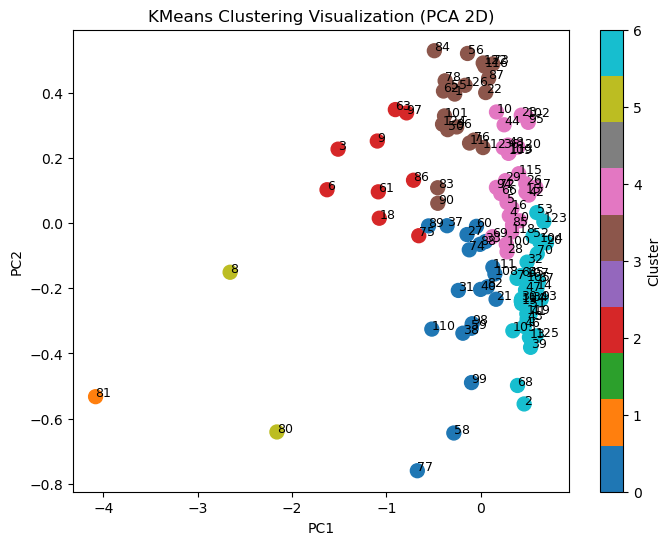

In [38]:
# Visualize stock clusters using PCA dimensionality reduction

# Reduce correlation matrix to 2D for visualization
pca = PCA(n_components=2)
corr_2d = pca.fit_transform(corr.values)

# Create scatter plot of stocks in 2D PCA space
plt.figure(figsize=(8, 6))
plt.scatter(corr_2d[:, 0], corr_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=100)

# Add stock ID labels to each point
for i, stock_id in enumerate(corr.index):
    plt.text(corr_2d[i, 0], corr_2d[i, 1], str(stock_id), fontsize=9)

plt.title("KMeans Clustering Visualization (PCA 2D)")
plt.xlabel("PC1")  
plt.ylabel("PC2") 
plt.colorbar(label='Cluster')
plt.show()

In [39]:
list_book_train = glob.glob(
    'data/optiver-realized-volatility-prediction/book_train.parquet/*')
list_trade_train = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_train.parquet/*')
train_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/train.csv')

time_length_list = [500,400,300,200,100]

In [40]:
df_train = preprocessor(list_book_train, list_trade_train,train_data,time_length_list)
df_test = preprocessor(list_book_test,list_trade_test,test_data,time_length_list,train=False)

0it [00:00, ?it/s]

112it [00:38,  2.92it/s]
1it [00:00, 90.60it/s]


## 1.5 Cross-sectional Volatility Features

This function creates historical context features by aggregating volatility statistics across two dimensions: individual stock histories and market-wide time periods. These features help capture both stock-specific volatility patterns and broader market regime characteristics.
The feature engineering approach:

1. Stock-level aggregation: Computes historical volatility statistics for each stock across all time periods
2. Time-level aggregation: Calculates cross-sectional volatility statistics across all stocks for each time period
3. Multi-timeframe analysis: Includes volatility measures from different interval lengths (200s, 300s, 400s, full period)
4. Statistical summaries: Captures mean, standard deviation, maximum, and minimum values for robust characterization
5. Contextual enrichment: Adds these aggregated features back to the original dataset for enhanced predictive power

This creates features that distinguish between stock-specific volatility patterns and market-wide volatility regimes occurring at specific time periods.

In [41]:
# Add stock and time-level volatility statistics as features
def get_time_stock(df):
    # Volatility columns across different time windows
    vol_cols = [
        'log_return1_realized_vol', 'log_return2_realized_vol',
        'log_return1_realized_vol_400', 'log_return2_realized_vol_400',
        'log_return1_realized_vol_300', 'log_return2_realized_vol_300',
        'log_return1_realized_vol_200', 'log_return2_realized_vol_200',
        'trade_log_return_realized_vol', 'trade_log_return_realized_vol_400',
        'trade_log_return_realized_vol_300', 'trade_log_return_realized_vol_200'
    ]
    
    # Stock-level volatility statistics
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_stock')
    
    # Time-level volatility statistics
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_time')
    
    # Merge back to original dataframe
    df = df.merge(df_stock_id, how='left', left_on=['stock_id'], right_on=['stock_id__stock'])
    df = df.merge(df_time_id, how='left', left_on=['time_id'], right_on=['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis=1, inplace=True)
    
    return df

In [42]:
df_train=get_time_stock(df_train)
df_test=get_time_stock(df_test)

## 1.6 Activity-based Feature

This section creates tau features that serve as activity-based scaling factors, capturing the intensity and distribution of trading activity across different timeframes. These features help normalize other metrics based on the underlying activity levels.
The tau feature construction includes:

1. Time-based tau: Inverse square root scaling based on temporal coverage, indicating how concentrated trading activity is within time buckets
2. Order-based tau: Scaling factors based on order count intensity with interval-specific weights (0.33, 0.5, 0.66)
3. Delta tau: Captures changes in activity intensity between different time intervals

These tau features provide important context about market activity patterns that can help models better interpret other technical indicators.

In [43]:
# Create tau features - activity-based scaling factors

# Time-based tau: inverse square root of unique time coverage
df_train['size_tau'] = np.sqrt(1 / df_train['seconds_in_bucket_unique'])
df_test['size_tau'] = np.sqrt(1 / df_test['seconds_in_bucket_unique'])

df_train['size_tau_400'] = np.sqrt(1 / df_train['seconds_in_bucket_unique_400'])
df_test['size_tau_400'] = np.sqrt(1 / df_test['seconds_in_bucket_unique_400'])

df_train['size_tau_300'] = np.sqrt(1 / df_train['seconds_in_bucket_unique_300'])
df_test['size_tau_300'] = np.sqrt(1 / df_test['seconds_in_bucket_unique_300'])

df_train['size_tau_200'] = np.sqrt(1 / df_train['seconds_in_bucket_unique_200'])
df_test['size_tau_200'] = np.sqrt(1 / df_test['seconds_in_bucket_unique_200'])

# Order-based tau: inverse square root of order count with scaling
df_train['size_tau2'] = np.sqrt(1 / df_train['order_count_sum'])
df_test['size_tau2'] = np.sqrt(1 / df_test['order_count_sum'])

df_train['size_tau2_400'] = np.sqrt(0.33 / df_train['order_count_sum'])
df_test['size_tau2_400'] = np.sqrt(0.33 / df_test['order_count_sum'])

df_train['size_tau2_300'] = np.sqrt(0.5 / df_train['order_count_sum'])
df_test['size_tau2_300'] = np.sqrt(0.5 / df_test['order_count_sum'])

df_train['size_tau2_200'] = np.sqrt(0.66 / df_train['order_count_sum'])
df_test['size_tau2_200'] = np.sqrt(0.66 / df_test['order_count_sum'])

# Delta tau - difference between interval and full period
df_train['size_tau2_d'] = df_train['size_tau2_400'] - df_train['size_tau2']
df_test['size_tau2_d'] = df_test['size_tau2_400'] - df_test['size_tau2']

## 1.7 Final Dataset Assembly

In [44]:
# Generate and merge cluster features
train_cluster = generate_cluster_features(df_train, cluster_stocks).reset_index()
train = pd.merge(df_train, train_cluster, how='left', on='time_id')

test_cluster = generate_cluster_features(df_test, cluster_stocks).reset_index()

# Extract time_id from row_id for test data
df_test['time_id'] = df_test['row_id'].str.split("-").str[1]
df_test['time_id'] = df_test['time_id'].astype(int)
test_cluster['time_id'] = test_cluster['time_id'].astype(int)

test = pd.merge(df_test, test_cluster, how='left', on='time_id')

# 2. Model Training
## 2.0 Cross-validation Setup

This section implements a cross-validation strategy specifically designed for time series financial data. Unlike standard random splitting, this approach ensures that validation folds are representative of the feature space while maintaining temporal structure.
The algorithm methodology:

1. Distance-based selection: Uses Euclidean distance in normalized feature space to create diverse yet representative folds
2. Iterative fold construction: Builds each fold sequentially by selecting points based on distance probabilities from existing fold centers
3. Feature space normalization: Applies MinMax scaling to prevent any single feature from dominating distance calculations
4. Probabilistic sampling: Converts distances to selection probabilities, ensuring closer points to fold centers have higher selection likelihood
5. Balanced representation: Ensures each fold captures different regions of the feature space for robust cross-validation

This creates more statistically sound validation splits compared to simple random partitioning, particularly important for financial time series where temporal dependencies and regime changes can significantly impact model performance.

In [45]:
nfolds = 5
n_time = train_p.shape[0]
distance_sum=[]
distance_sum = [np.zeros(n_time-nfolds) for _ in range(nfolds)]
selected_mat=[]
train_p = train_p.fillna(train_p.mean())
target_mat = train_p.values
target_mat = MinMaxScaler(feature_range=(-1, 1)).fit_transform(target_mat)
target_mat = np.c_[target_mat, range(n_time)]
num_per_fold = int(n_time/nfolds)

# Random select points to be the initial centers
centers = np.random.choice(np.array(n_time), size=nfolds, replace=False)
centers = np.sort(centers)[::-1]
# The index of rows that have been considered
ind_values = [[centers[i]] for i in range(nfolds)]

for i in range(nfolds):
    # The row that have been considered
    selected_mat.append(target_mat[ind_values[i], :])
    target_mat = np.delete(target_mat, obj=ind_values[i], axis=0)
    
for i in range(num_per_fold):
    for j in range(nfolds):
        threshold = np.random.uniform(0, 1, 1)
        # Match the size foe future matrix calculation
        selected_mat[j] = np.tile(selected_mat[j], (target_mat.shape[0], 1))
        distance_sum[j] += np.sum((target_mat[:, :-1] -
                               selected_mat[j][:, :-1])**2, axis=1)
        prob_vec = distance_sum[j]/np.sum(distance_sum[j])
        cum_prob = 0
        line_idx = 0
        for val in prob_vec:
            cum_prob += val
            if (cum_prob > threshold):  # the column was selected
                break
            line_idx += 1
        cum_prob = 0

        # Update parameters
        
        for n in range(nfolds):
            distance_sum[n] = np.delete(distance_sum[n].copy(), line_idx)
        centers[j] = line_idx
        selected_mat[j] = target_mat[line_idx, :]
        ind_values[j].append(target_mat[line_idx, -1])
        target_mat = np.delete(target_mat, obj=line_idx, axis=0)
  
    if target_mat.shape[0]==0:
        break
    
for ind in range(nfolds):
    ind_values[ind] = train_p.index[[int(term) for term in ind_values[ind]]]
    

## 2.1 LightGBM

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb
import torch

### 2.1.1 Evaluation Functions

In [47]:
# Root Mean Squared Percentage Error (RMSPE) implementations

# NumPy version for evaluation
def rmspe(y_true, y_pred):
    """Root mean squared percentage error - measures relative prediction accuracy"""
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# PyTorch version for neural network training
def RMSPELoss(y_pred, y_true):
    """RMSPE loss for PyTorch models"""
    return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2)).clone()

# LightGBM evaluation function
def rmspe_feval(y_pred, dataset):
    """RMSPE evaluation function for LightGBM"""
    y_true = dataset.get_label()
    return 'RMSPE', round(rmspe(y_true=y_true, y_pred=y_pred), 5), False

### 2.1.2 LightGBM Model Training

In [48]:
params = {
    "objective": "rmse",
    "metric": "rmse",
   
    "boosting_type": "gbdt",
  #   'min_data_in_leaf':500,
    'max_depth': -1,
    'subsample_freq': 4,
 
    'feature_fraction': 0.3,
    'bagging_fraction': 0.75,
    'learning_rate': 0.02,

    'lambda_l1': 0.5,
    'lambda_l2': 1.0,

}
def train_and_pred(train,test,params,n_splits = 5):
    feature_importances = pd.DataFrame()
    fold_scores=[]
    
    X = train.drop(['target'],axis=1)
    y = train['target']
    
    kfold = KFold(n_splits , random_state = 42, shuffle = True)
    test_pred= np.zeros(test.shape[0])
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}")
        
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_val, y_val = X.loc[val_idx], y[val_idx]

        weights_train = 1 / np.square(y_train.values)
        weights_val = 1 / np.square(y_val.values)

        X_train = X_train.drop(['row_id','time_id'],axis=1)
        X_val = X_val.drop(['row_id','time_id'],axis=1)
        features = X_train.columns.tolist()
        lgb_train = lgb.Dataset(X_train, label=y_train, weight=weights_train,
                                categorical_feature=['stock_id'])
        lgb_val = lgb.Dataset(X_val, label=y_val, weight=weights_val,
                            reference=lgb_train)
        model = lgb.train(
            params=params,
            train_set=lgb_train,
            num_boost_round=5000,
            feval=rmspe_feval,
            valid_sets=[lgb_train, lgb_val],
            callbacks=[lgb.early_stopping(
                stopping_rounds=50), lgb.log_evaluation(100)],

        )  

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
   
        test_pred += model.predict(test[features]) / 5
        rmse = rmspe(y_true=y_val, y_pred=y_pred)
        

        fold_scores.append(round(rmse,5))

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importance(
            importance_type='split')
        fold_importance["fold"] = fold + 1

        feature_importances = pd.concat(
            [feature_importances, fold_importance], axis=0)

    print(f"Average RMSE: {np.mean(fold_scores):.5f}")
    return feature_importances, test_pred

feature_importances,test_pred =  train_and_pred(train,test,params,n_splits = 5)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47230
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 215
[LightGBM] [Info] Start training from score 0.001797
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000514226	training's RMSPE: 0.23818	valid_1's rmse: 0.000536354	valid_1's RMSPE: 0.24744
[200]	training's rmse: 0.000464107	training's RMSPE: 0.21497	valid_1's rmse: 0.000492755	valid_1's RMSPE: 0.22733
[300]	training's rmse: 0.000450792	training's RMSPE: 0.2088	valid_1's rmse: 0.00048056	valid_1's RMSPE: 0.2217
[400]	training's rmse: 0.000442063	training's RMSPE: 0.20475	valid_1's rmse: 0.000473382	valid_1's RMSPE: 0.21839
[500]	training's rmse: 0.000435211	training's RMSPE: 0.20158	valid_1's

## 2.2 Neural Network
### 2.2.0 Setup for NN

In [49]:
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

tf.random.set_seed(42)

# Keras version of RMSPE loss function
def rmse_keras(y_true, y_pred):
    """RMSPE loss function for Keras models"""
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

# Early stopping callback - prevent overfitting
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min', restore_best_weights=True)

# Learning rate reduction callback - improve convergence
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

In [50]:
colNames = df_train.columns.tolist()
colNames.remove('row_id')
colNames.remove('target')
colNames.remove('time_id')
colNames.remove('stock_id')


### 2.2.1 Data Preperation

In [51]:
# Transform features to normal distribution for neural networks
qt_train = []
train_nn = train[colNames].copy()
test_nn = test[colNames].copy()

for col in colNames:
    qt = QuantileTransformer(random_state=42, n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])
    qt_train.append(qt)


In [52]:
# Add identifiers and targets to transformed data
train_nn[['stock_id', 'time_id', 'target']] = df_train[['stock_id', 'time_id', 'target']]

# Generate cluster features
train_cluster = generate_cluster_features(df_train, cluster_stocks).reset_index()
test_cluster = generate_cluster_features(df_test, cluster_stocks).reset_index()
test_cluster['time_id'] = test_cluster['time_id'].astype(int)

test_nn[['stock_id', 'time_id']] = df_test[['stock_id', 'time_id']]

# Merge cluster features with transformed data
train_nn = pd.merge(train_nn, train_cluster, how='left', on='time_id')
test_nn = pd.merge(test_nn, test_cluster, how='left', on='time_id')


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_95708/476974002.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_nn[['stock_id', 'time_id', 'target']] = df_train[['stock_id', 'time_id', 'target']]
/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_95708/476974002.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_nn[['stock_id', 'time_id', 'target']] = df_train[['stock_id', 'time_id', 'target']]
/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_95708/476974002.py:2: PerformanceWarning:

### 2.2.2 Model Defining

In [53]:

def swish(x, beta = 1):
    return (x * K.sigmoid(beta * x))

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)
stock_embedding_size = 24
cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(215,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        
    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

### 2.2.3 Model Training

In [54]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

from sklearn.model_selection import KFold
kfolds=5
kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
scores_folds[model_name] = []
counter = 1
colNames_0 = df_train.columns.tolist()
colNames_0.remove('row_id')
try:
    colNames_0.remove('pred_NN')
except:
    pass


df_test['stock_id']=df_test['row_id'].str.split("-").str[0]
df_test['stock_id'] = df_test['stock_id'].astype(int)
test_nn[['stock_id','time_id']]=df_test[['stock_id','time_id']]
test_nn[colNames] = test_nn[colNames].fillna(train_nn[colNames].mean())


train_nn = train_nn.fillna(0)
test_nn = test_nn.fillna(0)
test_predictions_nn = np.zeros(test_nn.shape[0])

test_nn[target_name] = 0
train_nn[pred_name] = 0

for n_count in range(kfolds):
    print('CV {}/{}'.format(counter, kfolds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[ind_values[indexes[0]],ind_values[indexes[1]],ind_values[indexes[2]],ind_values[indexes[3]]]
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), colNames_0]
    df_train_1 = df_train.loc[df_train.time_id.isin(indexes),colNames_0]
    train_cluster = generate_cluster_features(df_train_1, cluster_stocks).reset_index()
    train_cluster = train_cluster.fillna(0)

    X_train = pd.merge(X_train,train_cluster,how='left',on='time_id')
    

    X_test = train_nn.loc[train_nn.time_id.isin(ind_values[n_count]), colNames_0]
    df_train_0 = df_train.loc[df_train.time_id.isin(ind_values[n_count]),colNames_0]
    test_cluster = generate_cluster_features(df_train_0, cluster_stocks).reset_index()
    test_cluster = test_cluster.fillna(0)
    X_test = pd.merge(X_test,test_cluster,how='left',on='time_id')

    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    y_test = train_nn.loc[train_nn.time_id.isin(ind_values[n_count]), target_name]
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=rmse_keras
    )
    colNames_new = train_nn.columns.tolist()
 
    try:
        colNames_new.remove('row_id')
    except:
        pass
    colNames_new.remove('target')
    colNames_new.remove('time_id')
    '''try:
        colNames_new.remove('stock_id')
    except:
        pass'''
    try:
        colNames_new.remove('pred_NN')
    except:
        pass

    X_train = X_train.loc[:, colNames_new]
    X_test = X_test.loc[:, colNames_new]
    
    num_data = X_train[colNames_new]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[colNames_new]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    tt =scaler.transform(test_nn[colNames_new].values)

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    
    
    print(preds[:3])
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/kfolds
    print(test_predictions_nn[:3])
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    colNames_new.append('stock_id')

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_95708/3275547514.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_nn[target_name] = 0


CV 1/5


Epoch 1/1000
168/168 [==============================] - 2s 12ms/step - loss: 13.5426 - val_loss: 2.9000 - lr: 0.0060
Epoch 2/1000
168/168 [==============================] - 1s 5ms/step - loss: 4.3709 - val_loss: 2.7244 - lr: 0.0060
Epoch 3/1000
168/168 [==============================] - 1s 5ms/step - loss: 3.3323 - val_loss: 3.9513 - lr: 0.0060
Epoch 4/1000
168/168 [==============================] - 1s 5ms/step - loss: 1.7401 - val_loss: 1.2074 - lr: 0.0060
Epoch 5/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.9316 - val_loss: 0.8067 - lr: 0.0060
Epoch 6/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6695 - val_loss: 0.4640 - lr: 0.0060
Epoch 7/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6091 - val_loss: 0.6370 - lr: 0.0060
Epoch 8/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.5885 - val_loss: 0.7519 - lr: 0.0060
Epoch 9/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.

Epoch 1/1000
168/168 [==============================] - 1s 6ms/step - loss: 15.4434 - val_loss: 5.0384 - lr: 0.0060
Epoch 2/1000
168/168 [==============================] - 1s 5ms/step - loss: 3.1446 - val_loss: 2.6721 - lr: 0.0060
Epoch 3/1000
168/168 [==============================] - 1s 5ms/step - loss: 1.5033 - val_loss: 1.9154 - lr: 0.0060
Epoch 4/1000
168/168 [==============================] - 1s 5ms/step - loss: 1.3069 - val_loss: 1.0587 - lr: 0.0060
Epoch 5/1000
168/168 [==============================] - 1s 5ms/step - loss: 1.0064 - val_loss: 1.0172 - lr: 0.0060
Epoch 6/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.8915 - val_loss: 0.5510 - lr: 0.0060
Epoch 7/1000
168/168 [==============================] - 1s 6ms/step - loss: 1.1072 - val_loss: 1.0693 - lr: 0.0060
Epoch 8/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6910 - val_loss: 0.6166 - lr: 0.0060
Epoch 9/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6

Epoch 1/1000
168/168 [==============================] - 1s 6ms/step - loss: 10.3680 - val_loss: 1.2481 - lr: 0.0060
Epoch 2/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.8309 - val_loss: 0.6856 - lr: 0.0060
Epoch 3/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.7817 - val_loss: 0.9971 - lr: 0.0060
Epoch 4/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.7261 - val_loss: 0.7996 - lr: 0.0060
Epoch 5/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.6452 - val_loss: 0.5964 - lr: 0.0060
Epoch 6/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.6975 - val_loss: 0.7453 - lr: 0.0060
Epoch 7/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.5531 - val_loss: 0.4715 - lr: 0.0060
Epoch 8/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.4863 - val_loss: 0.4334 - lr: 0.0060
Epoch 9/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.7

Epoch 1/1000
168/168 [==============================] - 1s 6ms/step - loss: 10.6331 - val_loss: 3.8666 - lr: 0.0060
Epoch 2/1000
168/168 [==============================] - 1s 5ms/step - loss: 2.4842 - val_loss: 2.9921 - lr: 0.0060
Epoch 3/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.8928 - val_loss: 1.0217 - lr: 0.0060
Epoch 4/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.7250 - val_loss: 0.7678 - lr: 0.0060
Epoch 5/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.7056 - val_loss: 0.9669 - lr: 0.0060
Epoch 6/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6685 - val_loss: 0.6754 - lr: 0.0060
Epoch 7/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.6867 - val_loss: 0.7438 - lr: 0.0060
Epoch 8/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.6575 - val_loss: 0.5936 - lr: 0.0060
Epoch 9/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6

Epoch 1/1000
168/168 [==============================] - 1s 6ms/step - loss: 12.8093 - val_loss: 0.6910 - lr: 0.0060
Epoch 2/1000
168/168 [==============================] - 1s 5ms/step - loss: 2.7886 - val_loss: 1.4007 - lr: 0.0060
Epoch 3/1000
168/168 [==============================] - 1s 5ms/step - loss: 1.3908 - val_loss: 0.7435 - lr: 0.0060
Epoch 4/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6549 - val_loss: 0.8475 - lr: 0.0060
Epoch 5/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6086 - val_loss: 0.7040 - lr: 0.0060
Epoch 6/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.5385 - val_loss: 0.3357 - lr: 0.0060
Epoch 7/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.3046 - val_loss: 0.3356 - lr: 0.0060
Epoch 8/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.3152 - val_loss: 0.3360 - lr: 0.0060
Epoch 9/1000
168/168 [==============================] - 1s 6ms/step - loss: 0.8

# 3. Results

In [55]:
test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str) 
test_nn[target_name] = (test_predictions_nn+test_pred)/2

score = round(rmspe(y_true = train_nn[target_name].values, y_pred = train_nn[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test_nn)
test_nn[['row_id', target_name]].to_csv('submission.csv',index = False)


RMSPE NN: 1.0 - Folds: [0.21619, 0.22287, 0.21142, 0.20927, 0.21144]


/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_95708/3919126777.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str)


,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,wmp1_sum,wmp1_std,...,cluster_6_total_volume_sum,cluster_6_size_sum,cluster_6_order_count_sum,cluster_6_price_spread_sum,cluster_6_bid_spread_sum,cluster_6_ask_spread_sum,cluster_6_volume_imbalance_sum,cluster_6_size_tau2,target,row_id
0,-3.968637,-5.199338,-5.199338,-5.199338,-5.199338,-2.387690,-5.199338,-2.682197,-5.199338,-2.668400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002398,0-4
1,0.001254,0.001453,0.001412,0.004062,0.000398,0.004728,0.000390,0.003865,0.000405,0.004748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007181,0-32
2,0.001254,0.001453,0.001412,0.004062,0.000398,0.004728,0.000390,0.003865,0.000405,0.004748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007181,0-34
